In [1]:
import keras
import tensorflow
print(keras.__version__)
print(tensorflow.__version__)

2.15.0
2.15.0


In [5]:
!pip install tensorflow==2.15.0 keras==2.15.0 -q

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf


# Đọc dữ liệu
directory = "/content/gdrive/MyDrive/Data/data_split/Train"
test_directory = "/content/gdrive/MyDrive/Data/data_split/Test"
n_frames = 30 # số frame gom vào một record

X_train = []
y_train = []
X_test = []
y_test = []

id2label = {"0": "an", "1": "ban", "2": "ban dem",
              "3": "ban ngay", "4": "bo", "5": "cam on",
              "6": "choi", "7": "cuoi", "8": "di", "9": "di hoc",
              "10": "khoc", "11": "lam viec", "12": "me",
              "13": "moi ngay", "14": "sach", "15": "toi",
              "16": "viet", "17": "xem", "18": "xin chao", "19": "xin loi"}
label2id = {id2label[id]:int(id) for id in list(dict.keys(id2label))}
label2id

{'an': 0,
 'ban': 1,
 'ban dem': 2,
 'ban ngay': 3,
 'bo': 4,
 'cam on': 5,
 'choi': 6,
 'cuoi': 7,
 'di': 8,
 'di hoc': 9,
 'khoc': 10,
 'lam viec': 11,
 'me': 12,
 'moi ngay': 13,
 'sach': 14,
 'toi': 15,
 'viet': 16,
 'xem': 17,
 'xin chao': 18,
 'xin loi': 19}

In [4]:
def load_dir(directory):
    folder_list = os.listdir(directory)
    X, y = [], []
    for folder in folder_list:
        print('Processing', folder)
        path = os.path.join(directory,folder)
        files = os.listdir(path)
        for file in files:
            df = pd.read_csv(os.path.join(path,file),header=None)
            X.append(df.values)
            y.append(label2id[folder])
    return np.array(X), np.array(y)

X_train, y_train = load_dir(directory)
X_test, y_test = load_dir(test_directory)
X_train.shape, X_test.shape


Processing choi
Processing an
Processing ban
Processing cuoi
Processing cam on
Processing di
Processing ban dem
Processing ban ngay
Processing di hoc
Processing bo
Processing toi
Processing xem
Processing me
Processing xin chao
Processing sach
Processing xin loi
Processing moi ngay
Processing viet
Processing khoc
Processing lam viec
Processing ban ngay
Processing bo
Processing cuoi
Processing choi
Processing an
Processing di
Processing cam on
Processing di hoc
Processing ban dem
Processing ban
Processing toi
Processing xin loi
Processing khoc
Processing xin chao
Processing lam viec
Processing sach
Processing me
Processing moi ngay
Processing xem
Processing viet


((3668, 30, 258), (382, 30, 258))

In [ ]:
import json
with open('/content/drive/MyDrive/data_split/label_list_1DCNN_transformer.json','w') as f:
  json.dump(label2id,f)

In [5]:
# --------- Define auxiliary classes ---------

import keras
import tensorflow as tf

@keras.saving.register_keras_serializable(package="1DCNN_Transformer")
class ECA(tf.keras.layers.Layer):
    def __init__(self, kernel_size=5, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.kernel_size = kernel_size
        self.conv = tf.keras.layers.Conv1D(1, kernel_size=kernel_size, strides=1, padding="same", use_bias=False)

    def call(self, inputs, mask=None):
        nn = tf.keras.layers.GlobalAveragePooling1D()(inputs, mask=mask)
        nn = tf.expand_dims(nn, -1)
        nn = self.conv(nn)
        nn = tf.squeeze(nn, -1)
        nn = tf.nn.sigmoid(nn)
        nn = nn[:,None,:]
        return inputs * nn

    def get_config(self):
        base_config = super().get_config()
        config = {
            # "supports_masking" : keras.saving.serialize_keras_object(self.supports_masking),
            "kernel_size" : keras.saving.serialize_keras_object(self.kernel_size)
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls,config):
        kernel_size_config = config.pop("kernel_size")
        kernel_size = keras.saving.deserialize_keras_object(kernel_size_config)
        return cls(kernel_size, **config)

@keras.saving.register_keras_serializable(package="1DCNN_Transformer")
class LateDropout(tf.keras.layers.Layer):
    def __init__(self, rate, noise_shape=None, start_step=0, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.rate = rate
        self.noise_shape = noise_shape
        self.start_step = start_step
        self.dropout = tf.keras.layers.Dropout(rate, noise_shape=noise_shape)

    def build(self, input_shape):
        super().build(input_shape)
        agg = tf.VariableAggregation.ONLY_FIRST_REPLICA
        self._train_counter = tf.Variable(0, dtype="int64", aggregation=agg, trainable=False)

    def call(self, inputs, training=False):
        x = tf.cond(self._train_counter < self.start_step, lambda:inputs, lambda:self.dropout(inputs, training=training))
        if training:
            self._train_counter.assign_add(1)
        return x

    def get_config(self):
        base_config = super().get_config()
        config = {
            # "supports_masking" : keras.saving.serialize_keras_object(self.supports_masking),
            "rate" : keras.saving.serialize_keras_object(self.rate),
            "start_step" : keras.saving.serialize_keras_object(self.start_step),
            "noise_shape" : keras.saving.serialize_keras_object(self.noise_shape),
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls,config):
        rate_config = config.pop("rate")
        rate = keras.saving.deserialize_keras_object(rate_config)
        start_step_config = config.pop("start_step")
        start_step = keras.saving.deserialize_keras_object(start_step_config)
        noise_shape_config = config.pop("noise_shape")
        noise_shape = keras.saving.deserialize_keras_object(noise_shape_config)
        return cls(rate, noise_shape, start_step,  **config)

@keras.saving.register_keras_serializable(package="1DCNN_Transformer")
class CausalDWConv1D(tf.keras.layers.Layer):
    def __init__(self,
        kernel_size=17,
        dilation_rate=1,
        use_bias=False,
        depthwise_initializer='glorot_uniform',
        name='', **kwargs):
        super().__init__(name=name,**kwargs)
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate
        self.use_bias = use_bias
        self.depthwise_initializer=depthwise_initializer
        self.lname=name

        self.causal_pad = tf.keras.layers.ZeroPadding1D((dilation_rate*(kernel_size-1),0),name=name + '_pad')
        self.dw_conv = tf.keras.layers.DepthwiseConv1D(
                            kernel_size,
                            strides=1,
                            dilation_rate=dilation_rate,
                            padding='valid',
                            use_bias=use_bias,
                            depthwise_initializer=depthwise_initializer,
                            name=name + '_dwconv')
        self.supports_masking = True

    def call(self, inputs):
        x = self.causal_pad(inputs)
        x = self.dw_conv(x)
        return x

    def get_config(self):
        base_config = super().get_config()
        config = {
            "kernel_size" : keras.saving.serialize_keras_object(self.kernel_size),
            "dilation_rate" : keras.saving.serialize_keras_object(self.dilation_rate),
            "use_bias" : keras.saving.serialize_keras_object(self.use_bias),
            "depthwise_initializer" : keras.saving.serialize_keras_object(self.depthwise_initializer),
            "name" : keras.saving.serialize_keras_object(self.lname),
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls,config):
        kernel_size_config = config.pop("kernel_size")
        kernel_size = keras.saving.deserialize_keras_object(kernel_size_config)
        dilation_rate_config = config.pop("dilation_rate")
        dilation_rate = keras.saving.deserialize_keras_object(dilation_rate_config)
        bias_config = config.pop("use_bias")
        bias = keras.saving.deserialize_keras_object(bias_config)
        depthwise_config = config.pop("depthwise_initializer")
        depthwise = keras.saving.deserialize_keras_object(depthwise_config)
        name_config = config.pop("name")
        name = keras.saving.deserialize_keras_object(name_config)

        return cls(kernel_size,dilation_rate,bias,depthwise,name, **config)

def Conv1DBlock(channel_size,
          kernel_size,
          dilation_rate=1,
          drop_rate=0.0,
          expand_ratio=2,
          se_ratio=0.25,
          activation='swish',
          name=None):
    '''
    efficient conv1d block, @hoyso48
    '''
    if name is None:
        name = str(tf.keras.backend.get_uid("mbblock"))
    # Expansion phase
    def apply(inputs):
        channels_in = tf.keras.backend.int_shape(inputs)[-1]
        channels_expand = channels_in * expand_ratio

        skip = inputs

        x = tf.keras.layers.Dense(
            channels_expand,
            use_bias=True,
            activation=activation,
            name=name + '_expand_conv')(inputs)

        # Depthwise Convolution
        x = CausalDWConv1D(kernel_size,
            dilation_rate=dilation_rate,
            use_bias=False,
            name=name + '_dwconv')(x)

        x = tf.keras.layers.BatchNormalization(momentum=0.95, name=name + '_bn')(x)

        x  = ECA()(x)

        x = tf.keras.layers.Dense(
            channel_size,
            use_bias=True,
            name=name + '_project_conv')(x)

        if drop_rate > 0:
            x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1), name=name + '_drop')(x)

        if (channels_in == channel_size):
            x = tf.keras.layers.add([x, skip], name=name + '_add')
        return x

    return apply


@keras.saving.register_keras_serializable(package="1DCNN_Transformer")
class MultiHeadSelfAttention(tf.keras.layers.Layer):
    def __init__(self, dim=256, num_heads=4, dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.scale = self.dim ** -0.5
        self.num_heads = num_heads
        self.dropout = dropout
        self.qkv = tf.keras.layers.Dense(3 * dim, use_bias=False)
        self.drop1 = tf.keras.layers.Dropout(dropout)
        self.proj = tf.keras.layers.Dense(dim, use_bias=False)
        self.supports_masking = True

    def call(self, inputs, mask=None):
        qkv = self.qkv(inputs)
        qkv = tf.keras.layers.Permute((2, 1, 3))(tf.keras.layers.Reshape((-1, self.num_heads, self.dim * 3 // self.num_heads))(qkv))
        q, k, v = tf.split(qkv, [self.dim // self.num_heads] * 3, axis=-1)

        attn = tf.matmul(q, k, transpose_b=True) * self.scale

        if mask is not None:
            mask = mask[:, None, None, :]

        attn = tf.keras.layers.Softmax(axis=-1)(attn, mask=mask)
        attn = self.drop1(attn)

        x = attn @ v
        x = tf.keras.layers.Reshape((-1, self.dim))(tf.keras.layers.Permute((2, 1, 3))(x))
        x = self.proj(x)
        return x

    def get_config(self):
        base_config = super().get_config()
        config = {
            "dim" : self.dim,
            "num_heads" : self.num_heads,
            "dropout" : self.dropout,
        }
        return {**base_config, **config}

    @classmethod
    def from_config(cls,config):
        dim_config = config.pop("dim")
        dim = keras.saving.deserialize_keras_object(dim_config)
        num_heads_config = config.pop("num_heads")
        num_heads = keras.saving.deserialize_keras_object(num_heads_config)
        dropout_config = config.pop("dropout")
        dropout = keras.saving.deserialize_keras_object(dropout_config)
        return cls(dim,num_heads,dropout)

def TransformerBlock(dim=256, num_heads=4, expand=4, attn_dropout=0.2, drop_rate=0.2, activation='swish'):
    def apply(inputs):
        x = inputs
        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = MultiHeadSelfAttention(dim=dim,num_heads=num_heads,dropout=attn_dropout)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([inputs, x])
        attn_out = x

        x = tf.keras.layers.BatchNormalization(momentum=0.95)(x)
        x = tf.keras.layers.Dense(dim*expand, use_bias=False, activation=activation)(x)
        x = tf.keras.layers.Dense(dim, use_bias=False)(x)
        x = tf.keras.layers.Dropout(drop_rate, noise_shape=(None,1,1))(x)
        x = tf.keras.layers.Add()([attn_out, x])
        return x
    return apply

In [13]:
MAX_LEN = 30 # number of frame
CHANNELS = 258 # number of keypoint value
NUM_CLASSES = 20
PAD = -100

# ----------------------------------------- DEFINE MODEL -----------------------------
def get_model(max_len=MAX_LEN, dropout_step=0, dim=96):
    inp = tf.keras.Input((max_len,CHANNELS))
    # x = tf.keras.layers.Masking(mask_value=PAD,input_shape=(max_len,CHANNELS))(inp) #we don't need masking layer with inference
    x = inp
    ksize = 3
    x = tf.keras.layers.Permute((2,1))(x)
    x = tf.keras.layers.Dense(dim, use_bias=False,name='stem_conv')(x)
    x = tf.keras.layers.BatchNormalization(momentum=0.95,name='stem_bn')(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = TransformerBlock(dim,expand=2)(x)

    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
    x = TransformerBlock(dim,expand=2)(x)

    if dim == 384: #for the 4x sized model
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = TransformerBlock(dim,expand=2)(x)

        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = Conv1DBlock(dim,ksize,drop_rate=0.2)(x)
        x = TransformerBlock(dim,expand=2)(x)

    x = tf.keras.layers.Dense(dim*2,activation=None,name='top_conv')(x)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = LateDropout(0.5, start_step=dropout_step)(x)
    x = tf.keras.layers.Dense(NUM_CLASSES,name='classifier',activation="softmax")(x)
    return tf.keras.Model(inp, x)

In [14]:
model = get_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 30, 258)]            0         []                            
                                                                                                  
 permute_1 (Permute)         (None, 258, 30)              0         ['input_2[0][0]']             
                                                                                                  
 stem_conv (Dense)           (None, 258, 96)              2880      ['permute_1[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 258, 96)              384       ['stem_conv[0][0]']           
 n)                                                                                         

In [24]:
import keras
keras.__version__

'2.15.0'

In [7]:
# from keras.models import load_model
# model = load_model("/content/gdrive/MyDrive/AI4LIFE - AIMateur/1DCNN_Transformer_CT_CT_n30.keras",
#                    custom_objects={
#                        "CausalDWConv1D":CausalDWConv1D,
#                        "MultiHeadSelfAttention":MultiHeadSelfAttention,
#                        "ECA":ECA,
#                        "LateDropout":LateDropout
#                    })

TypeError: Could not deserialize class 'Functional' because its parent module keras.src.models.functional cannot be imported. Full object config: {'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'functional_1', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 30, 132], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None, 'name': 'input_layer', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': '1_expand_conv', 'trainable': True, 'dtype': 'float32', 'units': 264, 'activation': 'silu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 132]}, 'name': '1_expand_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 132], 'dtype': 'float32', 'keras_history': ['input_layer', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'CausalDWConv1D', 'config': {'name': '1_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': 3, 'dilation_rate': 1, 'use_bias': False, 'depthwise_initializer': 'glorot_uniform'}, 'registered_name': '1DCNN_Transformer>CausalDWConv1D', 'build_config': {'input_shape': [None, 30, 264]}, 'name': '1_dwconv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 264], 'dtype': 'float32', 'keras_history': ['1_expand_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': '1_bn', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.95, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 264]}, 'name': '1_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 264], 'dtype': 'float32', 'keras_history': ['1_dwconv', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': None, 'class_name': 'ECA', 'config': {'name': 'eca', 'trainable': True, 'dtype': 'float32', 'kernel_size': 5}, 'registered_name': '1DCNN_Transformer>ECA', 'build_config': {'input_shape': [None, 30, 264]}, 'name': 'eca', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 264], 'dtype': 'float32', 'keras_history': ['1_bn', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': '1_project_conv', 'trainable': True, 'dtype': 'float32', 'units': 192, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 264]}, 'name': '1_project_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 264], 'dtype': 'float32', 'keras_history': ['eca', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': '1_drop', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': [None, 1, 1]}, 'registered_name': None, 'name': '1_drop', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 192], 'dtype': 'float32', 'keras_history': ['1_project_conv', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.95, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 192]}, 'name': 'batch_normalization', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 192], 'dtype': 'float32', 'keras_history': ['1_drop', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': None, 'class_name': 'MultiHeadSelfAttention', 'config': {'name': 'multi_head_self_attention', 'trainable': True, 'dtype': 'float32', 'dim': 192, 'num_heads': 4, 'dropout': 0.2}, 'registered_name': '1DCNN_Transformer>MultiHeadSelfAttention', 'build_config': {'input_shape': [None, 30, 192]}, 'name': 'multi_head_self_attention', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 192], 'dtype': 'float32', 'keras_history': ['batch_normalization', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_1', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': [None, 1, 1]}, 'registered_name': None, 'name': 'dropout_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 192], 'dtype': 'float32', 'keras_history': ['multi_head_self_attention', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 30, 192], [None, 30, 192]]}, 'name': 'add', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 192], 'dtype': 'float32', 'keras_history': ['1_drop', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 192], 'dtype': 'float32', 'keras_history': ['dropout_1', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_1', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.95, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 192]}, 'name': 'batch_normalization_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 192], 'dtype': 'float32', 'keras_history': ['add', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_2', 'trainable': True, 'dtype': 'float32', 'units': 384, 'activation': 'silu', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 192]}, 'name': 'dense_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 192], 'dtype': 'float32', 'keras_history': ['batch_normalization_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_3', 'trainable': True, 'dtype': 'float32', 'units': 192, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 384]}, 'name': 'dense_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 384], 'dtype': 'float32', 'keras_history': ['dense_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_2', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': [None, 1, 1]}, 'registered_name': None, 'name': 'dropout_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 192], 'dtype': 'float32', 'keras_history': ['dense_3', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_1', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 30, 192], [None, 30, 192]]}, 'name': 'add_1', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 192], 'dtype': 'float32', 'keras_history': ['add', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 192], 'dtype': 'float32', 'keras_history': ['dropout_2', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': '2_expand_conv', 'trainable': True, 'dtype': 'float32', 'units': 384, 'activation': 'silu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 192]}, 'name': '2_expand_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 192], 'dtype': 'float32', 'keras_history': ['add_1', 0, 0]}}], 'kwargs': {}}]}, {'module': None, 'class_name': 'CausalDWConv1D', 'config': {'name': '2_dwconv', 'trainable': True, 'dtype': 'float32', 'kernel_size': 3, 'dilation_rate': 1, 'use_bias': False, 'depthwise_initializer': 'glorot_uniform'}, 'registered_name': '1DCNN_Transformer>CausalDWConv1D', 'build_config': {'input_shape': [None, 30, 384]}, 'name': '2_dwconv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 384], 'dtype': 'float32', 'keras_history': ['2_expand_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': '2_bn', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.95, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 384]}, 'name': '2_bn', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 384], 'dtype': 'float32', 'keras_history': ['2_dwconv', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': None, 'class_name': 'ECA', 'config': {'name': 'eca_1', 'trainable': True, 'dtype': 'float32', 'kernel_size': 5}, 'registered_name': '1DCNN_Transformer>ECA', 'build_config': {'input_shape': [None, 30, 384]}, 'name': 'eca_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 384], 'dtype': 'float32', 'keras_history': ['2_bn', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': '2_project_conv', 'trainable': True, 'dtype': 'float32', 'units': 192, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 384]}, 'name': '2_project_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 384], 'dtype': 'float32', 'keras_history': ['eca_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': '2_drop', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': [None, 1, 1]}, 'registered_name': None, 'name': '2_drop', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 192], 'dtype': 'float32', 'keras_history': ['2_project_conv', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': '2_add', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 30, 192], [None, 30, 192]]}, 'name': '2_add', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 192], 'dtype': 'float32', 'keras_history': ['2_drop', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 192], 'dtype': 'float32', 'keras_history': ['add_1', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_2', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.95, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 192]}, 'name': 'batch_normalization_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 192], 'dtype': 'float32', 'keras_history': ['2_add', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': None, 'class_name': 'MultiHeadSelfAttention', 'config': {'name': 'multi_head_self_attention_1', 'trainable': True, 'dtype': 'float32', 'dim': 192, 'num_heads': 4, 'dropout': 0.2}, 'registered_name': '1DCNN_Transformer>MultiHeadSelfAttention', 'build_config': {'input_shape': [None, 30, 192]}, 'name': 'multi_head_self_attention_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 192], 'dtype': 'float32', 'keras_history': ['batch_normalization_2', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_4', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': [None, 1, 1]}, 'registered_name': None, 'name': 'dropout_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 192], 'dtype': 'float32', 'keras_history': ['multi_head_self_attention_1', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_2', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 30, 192], [None, 30, 192]]}, 'name': 'add_2', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 192], 'dtype': 'float32', 'keras_history': ['2_add', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 192], 'dtype': 'float32', 'keras_history': ['dropout_4', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_3', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.95, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 192]}, 'name': 'batch_normalization_3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 192], 'dtype': 'float32', 'keras_history': ['add_2', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_6', 'trainable': True, 'dtype': 'float32', 'units': 384, 'activation': 'silu', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 192]}, 'name': 'dense_6', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 192], 'dtype': 'float32', 'keras_history': ['batch_normalization_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense_7', 'trainable': True, 'dtype': 'float32', 'units': 192, 'activation': 'linear', 'use_bias': False, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 384]}, 'name': 'dense_7', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 384], 'dtype': 'float32', 'keras_history': ['dense_6', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_5', 'trainable': True, 'dtype': 'float32', 'rate': 0.2, 'seed': None, 'noise_shape': [None, 1, 1]}, 'registered_name': None, 'name': 'dropout_5', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 192], 'dtype': 'float32', 'keras_history': ['dense_7', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Add', 'config': {'name': 'add_3', 'trainable': True, 'dtype': 'float32'}, 'registered_name': None, 'build_config': {'input_shape': [[None, 30, 192], [None, 30, 192]]}, 'name': 'add_3', 'inbound_nodes': [{'args': [[{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 192], 'dtype': 'float32', 'keras_history': ['add_2', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 192], 'dtype': 'float32', 'keras_history': ['dropout_5', 0, 0]}}]], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'top_conv', 'trainable': True, 'dtype': 'float32', 'units': 384, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 192]}, 'name': 'top_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 192], 'dtype': 'float32', 'keras_history': ['add_3', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling1D', 'config': {'name': 'global_average_pooling1d_4', 'trainable': True, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 30, 384]}, 'name': 'global_average_pooling1d_4', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 30, 384], 'dtype': 'float32', 'keras_history': ['top_conv', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'classifier', 'trainable': True, 'dtype': 'float32', 'units': 22, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 384]}, 'name': 'classifier', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 384], 'dtype': 'float32', 'keras_history': ['global_average_pooling1d_4', 0, 0]}}], 'kwargs': {}}]}], 'input_layers': [['input_layer', 0, 0]], 'output_layers': [['classifier', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'SGD', 'config': {'name': 'SGD', 'learning_rate': 5.98736951360479e-05, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'momentum': 0.0, 'nesterov': False}, 'registered_name': None}, 'loss': 'sparse_categorical_crossentropy', 'loss_weights': None, 'metrics': ['accuracy'], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}

In [21]:
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.optimizers import AdamW, SGD, Adamax

# def scheduler(epoch,lr):
#     return lr*0.97
# lr_scheduler = LearningRateScheduler(scheduler)
model = get_model()
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.8,
                              patience=5, min_lr=5e-6)

checkpoint = ModelCheckpoint(
    filepath="/content/drive/MyDrive/data_split/1DCNN_Transformer_L-dim192_train9_1405_checkpoint.weights.h5",
    save_best_only=True,
    save_weights_only=True,
)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, start_from_epoch=20)

model.compile(loss="sparse_categorical_crossentropy",
              metrics=["accuracy"],
              optimizer=AdamW(5e-5))

In [22]:
batch_size = 256
epochs = 150

history = model.fit(X_train,y_train,
                    shuffle=True,
                    validation_data = (X_test,y_test),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[lr_scheduler,early_stopping,checkpoint])
# model.save("/content/drive/MyDrive/PBL5_Nhandienthungu/Data/data_split/1DCNN_Transformer_train5_1405",save_format='tf')

Epoch 1/150
15/15 [==============================] - 22s 480ms/step - loss: 3.3051 - accuracy: 0.0491 - val_loss: 3.0194 - val_accuracy: 0.0471 - lr: 5.0000e-05
Epoch 2/150
15/15 [==============================] - 5s 357ms/step - loss: 3.1022 - accuracy: 0.0867 - val_loss: 2.9868 - val_accuracy: 0.0576 - lr: 5.0000e-05
Epoch 3/150
15/15 [==============================] - 5s 354ms/step - loss: 2.9578 - accuracy: 0.1210 - val_loss: 2.9576 - val_accuracy: 0.0864 - lr: 5.0000e-05
Epoch 4/150
15/15 [==============================] - 5s 363ms/step - loss: 2.8854 - accuracy: 0.1439 - val_loss: 2.9212 - val_accuracy: 0.1283 - lr: 5.0000e-05
Epoch 5/150
15/15 [==============================] - 5s 348ms/step - loss: 2.8064 - accuracy: 0.1527 - val_loss: 2.8650 - val_accuracy: 0.1283 - lr: 5.0000e-05
Epoch 6/150
15/15 [==============================] - 5s 362ms/step - loss: 2.7465 - accuracy: 0.1614 - val_loss: 2.7787 - val_accuracy: 0.1780 - lr: 5.0000e-05
Epoch 7/150
15/15 [====================

In [23]:
history_data = history.history
h = pd.DataFrame(history_data)
h.to_csv('/content/gdrive/MyDrive/data_split/1DCNN_Transformer_L-dim96_train10_1405_history.csv')
# model.save("/content/drive/MyDrive/PBL5_Nhandienthungu/Data/data_split/1DCNN_Transformer_train10_1405",save_format='tf')

In [24]:
model.save_weights("/content/gdrive/MyDrive/data_split/1DCNN_Transformer_L-dim96_train10_1405-100epochs.weights.h5")

In [25]:
import gc
gc.collect()

9580

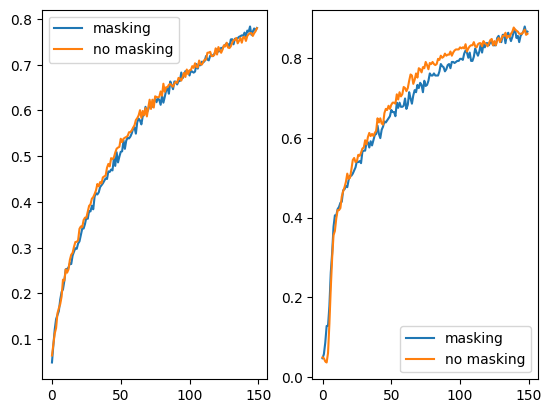

In [35]:
import matplotlib.pyplot as plt

df1 = pd.read_csv('/content/gdrive/MyDrive/data_split/1DCNN_Transformer_L-dim96_train10_1405_history.csv')
df2 = pd.read_csv('/content/gdrive/MyDrive/data_split/1DCNN_Transformer_L-dim96_train10_1405_history_no_masking.csv')
# print(df2)
plt.subplot(1, 2, 1)
plt.plot(df1["accuracy"])
plt.plot(df2["accuracy"])
plt.legend(["masking", "no masking"])
plt.subplot(1, 2, 2)
plt.plot(df1["val_accuracy"])
plt.plot(df2["val_accuracy"])
plt.legend(["masking", "no masking"])
plt.show()